┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


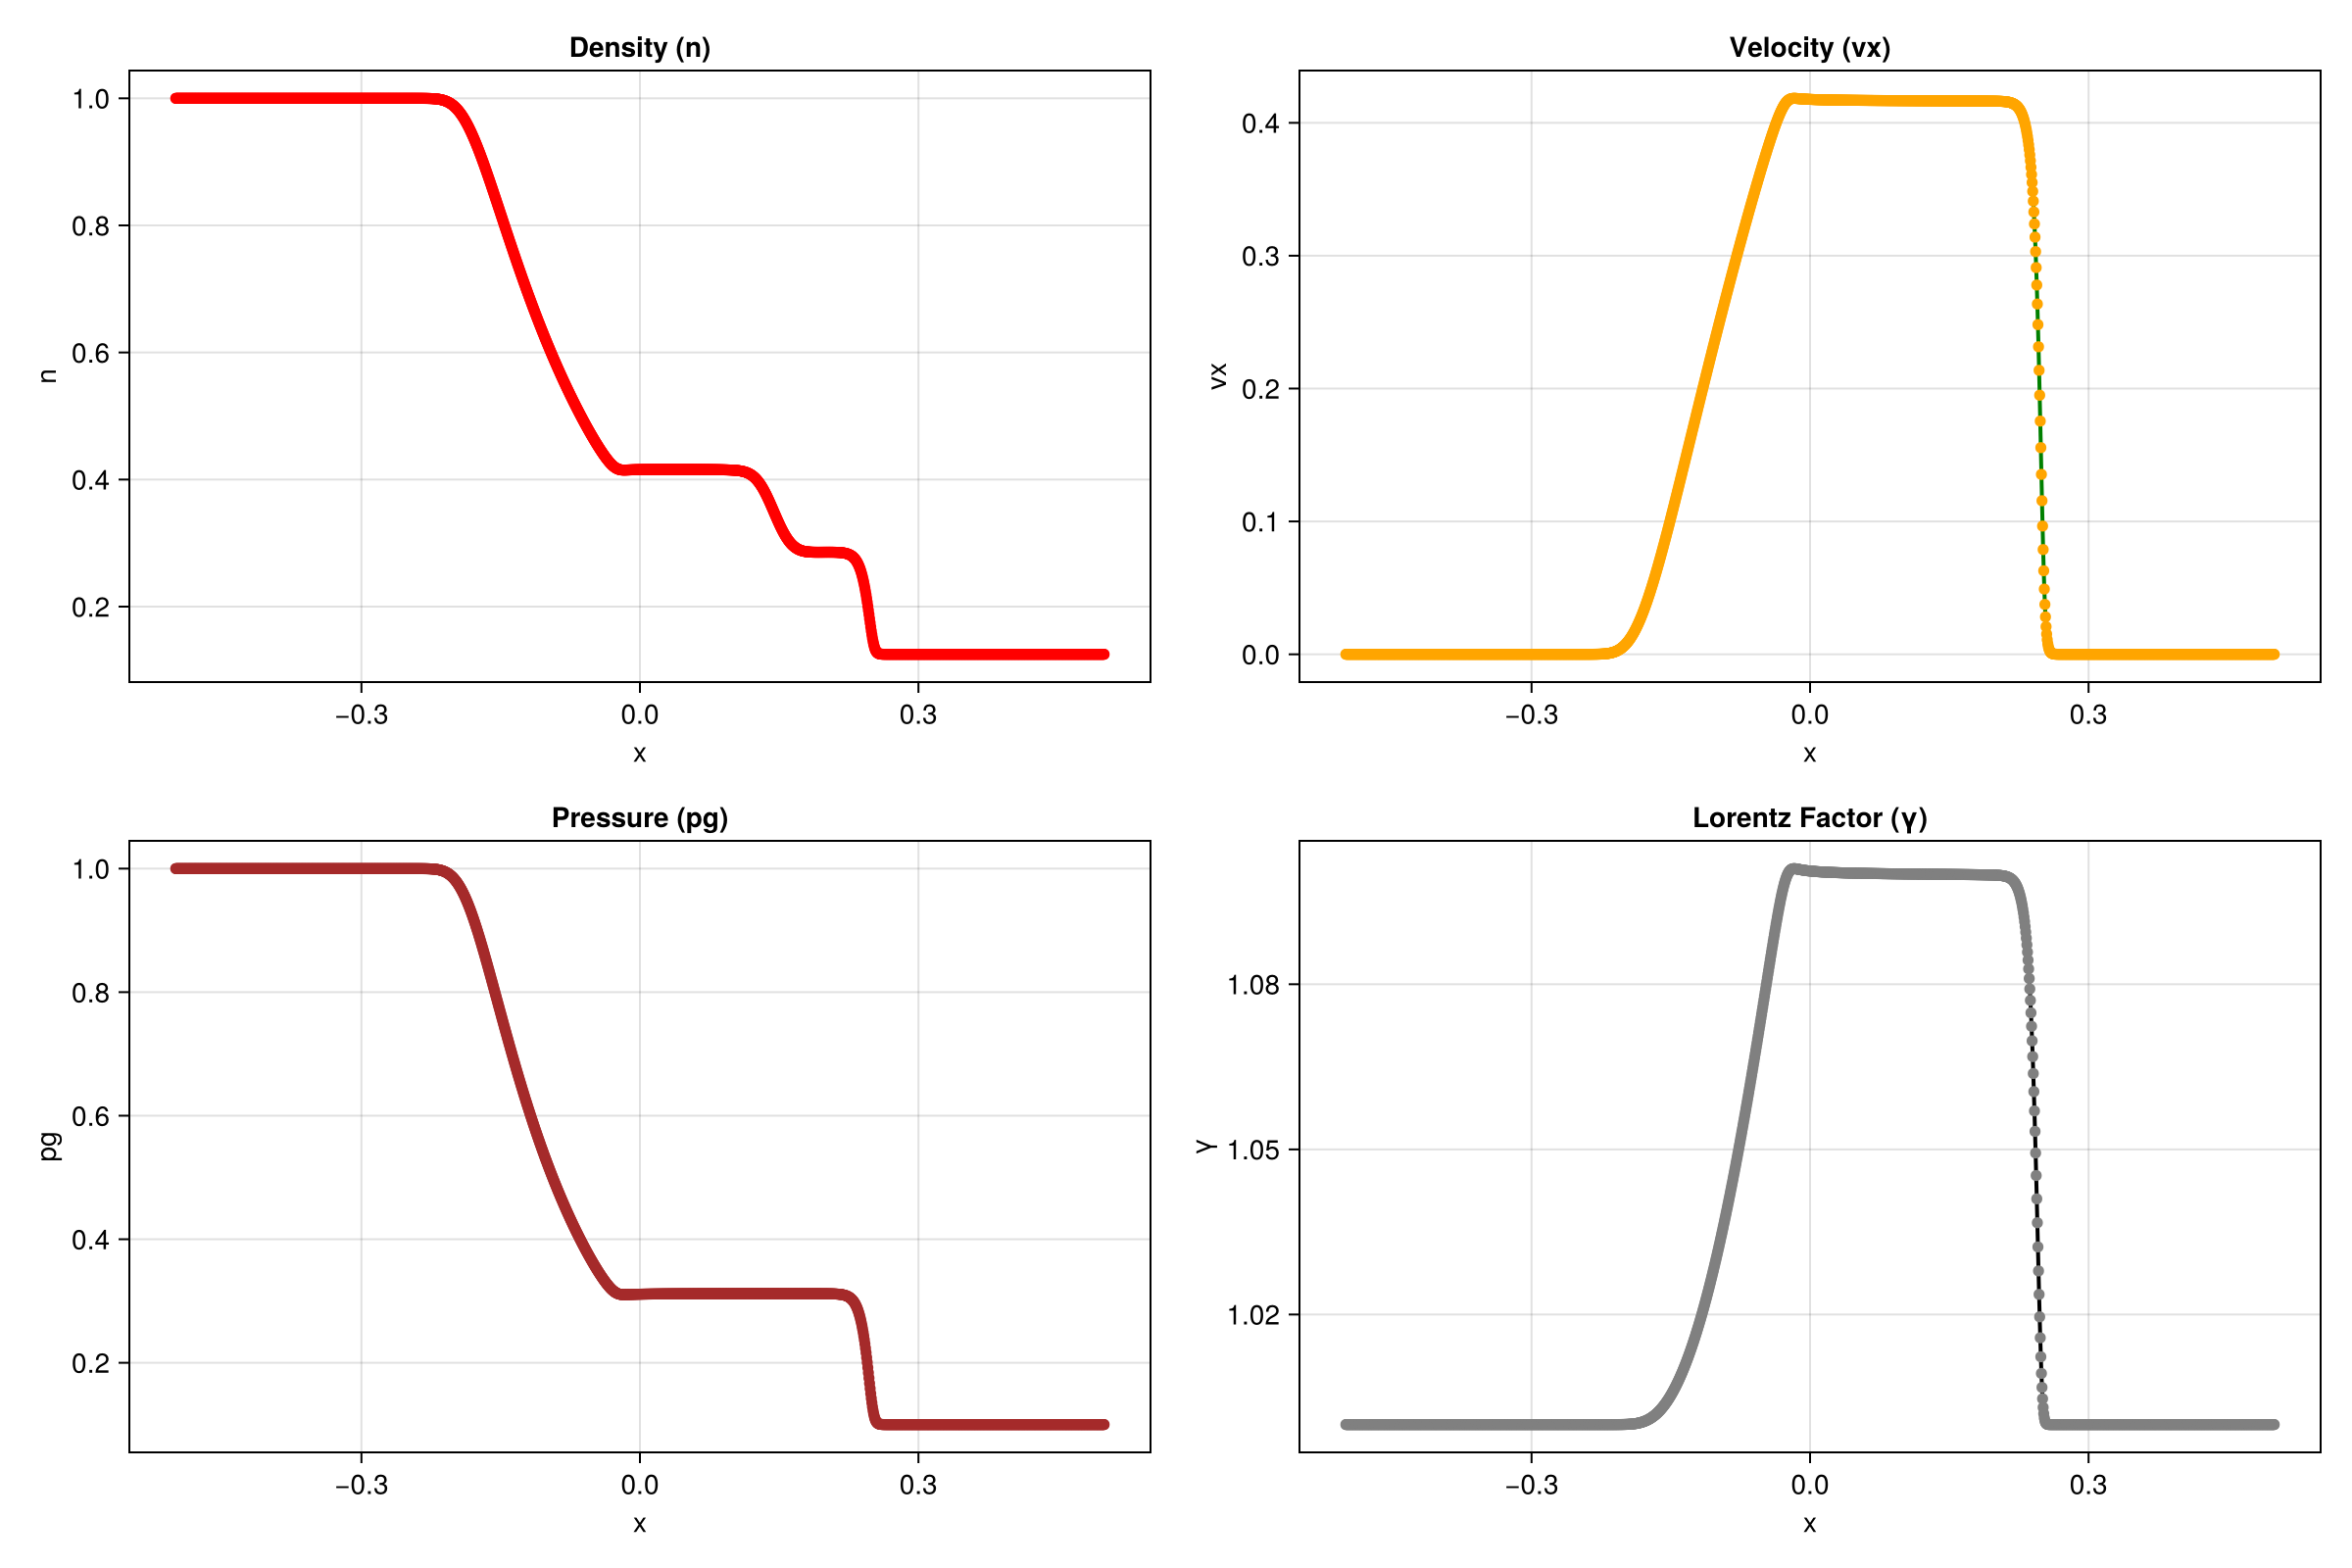

In [19]:
using CairoMakie 
using Roots 
using LinearAlgebra

#### Constants required for simulations #####

const N_L = 1600
const Γ = 1.333
const xL = -0.5
const xR = 0.5
const small = 1e-12
const big = 1e12
const CFL = 0.2
const tf = 0.35

x = LinRange(xL,xR,N_L)
dx = (xR - xL) / N_L

function Lorentz(vx)
    v2 = vx*vx
    if v2 > 1 - small
        println("Warning v2 is close to 1.0")
        clamp(v2,small,1-small)
    end
    return clamp(sqrt(1/(1 - v2)),1.0,big)
end

function prim_to_cons(u)
    n,vx,pg = u 
    γ = Lorentz(vx)
    e = pg/(Γ - 1) + n
    N_cons = n*γ
    Mx = (γ^2)*(e + pg) * vx
    E = (γ^2)*(e + pg) - pg
    if E < N_cons || E < Mx
        println("Physical constrains violated")
    end
    return [N_cons, Mx, E]
end

function prim_to_flux(u)
    n,vx,pg = u
    γ = Lorentz(vx)
    e = pg/(Γ - 1) + n
    N_cons = n*γ
    Mx = (γ^2)*(e + pg) * vx
    E = (γ^2)*(e + pg) - pg
    return [vx*N_cons, Mx*vx + pg , E*vx + pg*vx]
end

function cons_to_prim(U)
    N_cons , Mx , E = U
    function g(vx) 
        e_val = E - vx * Mx 
        n_val = N_cons * sqrt(1 - vx*vx) 
        P = (Γ - 1)*(e_val - n_val)
        return vx * ( E + P) - Mx
    end

    v_root = find_zero(g,(-1 + small, 1 - small), atol = small)
    if g(v_root) > small 
        println("roots are not in within tolerance ", [v_root, g(v_root)])
    end
    nr = N_cons/(Lorentz(v_root))
    er = E - v_root*Mx
    pg = (Γ - 1)*(er - nr)
    return [nr,v_root,pg]
end

function sound_speed(n,pg)
    e = pg/(Γ - 1) + n
    cs2 = (Γ*(Γ - 1)*(e - n))/ (n + Γ*(e - n))
    if cs2 > 1.0 - small || cs2 < small
        clamp(cs2,small, 1 - small)
    end
    return [cs2, sqrt(cs2)]
end 

function HLLE_bound_speeds(uL,uR)
    nL,vxL,pgL = uL 
    nR,vxR,pgR = uR 

    cs2L , csL = sound_speed(nL,pgL)
    cs2R , csR = sound_speed(nR,pgR)

    v_bar = 0.5*(vxL + vxR)
    cs_bar = 0.5*(csL + csR)

    λL = min(0.0, (v_bar - cs_bar) / (1 - v_bar*cs_bar), (vxL - csL) / ( 1 - vxL*csL) )
    λR = max(0.0, (v_bar + cs_bar) / (1 + v_bar*cs_bar), (vxR + csR) / ( 1 + vxR*csR) )

    return [λL , λR] 
end

function HLLE_flux(uL,uR)
    SL , SR = HLLE_bound_speeds(uL,uR)
    FL = prim_to_flux(uL) 
    FR = prim_to_flux(uR)
    UR = prim_to_cons(uR)
    UL = prim_to_cons(uL)

    if SL >= 0 
        return FL
    elseif SR <= 0
        return FR
    else 
        return (SR .* FL - SL .* FR + SL .* SR .* (UR .- UL)) ./ (SR .- SL)
    end
end

function maximum_signal(u)
    S_max = 0.0
    for i in 1:length(u)
        ni , vxi , pgi = u[i]
        cs2i , csi = sound_speed(ni,pgi)
        SL  = abs((vxi - csi) / (1 - vxi*csi))
        SR  = abs((vxi + csi) / (1 + vxi*csi))
        S_max = max(S_max, SL, SR)
    end
    return S_max
end

function minmod_slope_limiter_c(u)
    NC = length(u)
    uL = deepcopy(u)
    uR = deepcopy(u)
    
    for j in 2:NC-1
        u_jp1 = u[j+1]
        u_j = u[j]
        u_jm1 = u[j-1]
        
        sp = u_jp1 .- u_j
        sm = u_j .- u_jm1
        
        du = zeros(length(u_j))
        
        for comp in 1:length(u_j)
            if sp[comp] * sm[comp] > 0.0
                du[comp] = 0.5 * sign(sp[comp]) * min(abs(sp[comp]), abs(sm[comp]))
            else
                du[comp] = 0.0
            end
        end
        
        uL[j] = u_j .- du
        uR[j-1] = u_j .+ du
    end
    
    return uL, uR
end

# Initial condition (Sod shock tube) - FIXED
function initial_condition(x)
    u_prim = Vector{Vector{Float64}}(undef, length(x))
    for i in 1:length(x)
        if x[i] < 0
            u_prim[i] = [1.0, 0.0, 1.0]  # Left state
        else
            u_prim[i] = [0.125, 0.0, 0.1]  # Right state
        end
    end
    return u_prim
end

# Initialize simulation
u_prim = initial_condition(x)
U = [prim_to_cons(u) for u in u_prim] 
U_half_L = deepcopy(U)
U_half_R = deepcopy(U)
U_new = deepcopy(U)

t = 0.0

while t < tf
    dt = CFL * dx / maximum_signal(u_prim)
    u_L, u_R = minmod_slope_limiter_c(u_prim)
    
    for i in 2:N_L-1 
        FL = prim_to_flux(u_L[i])
        FR = prim_to_flux(u_R[i])
        U_half_L[i] = prim_to_cons(u_L[i]) .- 0.5 * (dt / dx) .* (FR .- FL)
        U_half_R[i] = prim_to_cons(u_R[i]) .- 0.5 * (dt / dx) .* (FR .- FL) 
    end

    for j in 2:N_L-1
        uLHL = cons_to_prim(U_half_L[j-1])
        uRHL = cons_to_prim(U_half_R[j-1])
        uLHR = cons_to_prim(U_half_L[j])
        uRHR = cons_to_prim(U_half_R[j])

        F_L = HLLE_flux(uLHL, uRHL)
        F_R = HLLE_flux(uLHR, uRHR)

        U_new[j] = U[j] .- (dt / dx) .* (F_R .- F_L)
    end

    U_new[1], U_new[end] = U_new[2], U_new[end-1]
    U .= U_new
    u_prim = [cons_to_prim(u) for u in U_new]
    global t += dt
end

# println("Final primitive variables:")
# for (i, u) in enumerate(u_prim)
#     println("Cell $i: n=$(u[1]), vx=$(u[2]), pg=$(u[3])")
# end
# Extract the primitive variables for plotting
n_values = [u[1] for u in u_prim]
vx_values = [u[2] for u in u_prim]
pg_values = [u[3] for u in u_prim]

# Create the figure
fig = Figure(resolution = (1200, 800))

# Density plot
ax1 = Axis(fig[1, 1], title = "Density (n)", xlabel = "x", ylabel = "n")
lines!(ax1, x, n_values, color = :blue, linewidth = 2)
scatter!(ax1, x, n_values, color = :red, markersize = 8)

# Velocity plot
ax2 = Axis(fig[1, 2], title = "Velocity (vx)", xlabel = "x", ylabel = "vx")
lines!(ax2, x, vx_values, color = :green, linewidth = 2)
scatter!(ax2, x, vx_values, color = :orange, markersize = 8)

# Pressure plot
ax3 = Axis(fig[2, 1], title = "Pressure (pg)", xlabel = "x", ylabel = "pg")
lines!(ax3, x, pg_values, color = :purple, linewidth = 2)
scatter!(ax3, x, pg_values, color = :brown, markersize = 8)

# Lorentz factor plot
γ_values = [Lorentz(u[2]) for u in u_prim]
ax4 = Axis(fig[2, 2], title = "Lorentz Factor (γ)", xlabel = "x", ylabel = "γ")
lines!(ax4, x, γ_values, color = :black, linewidth = 2)
scatter!(ax4, x, γ_values, color = :gray, markersize = 8)



# Adjust padding and display
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


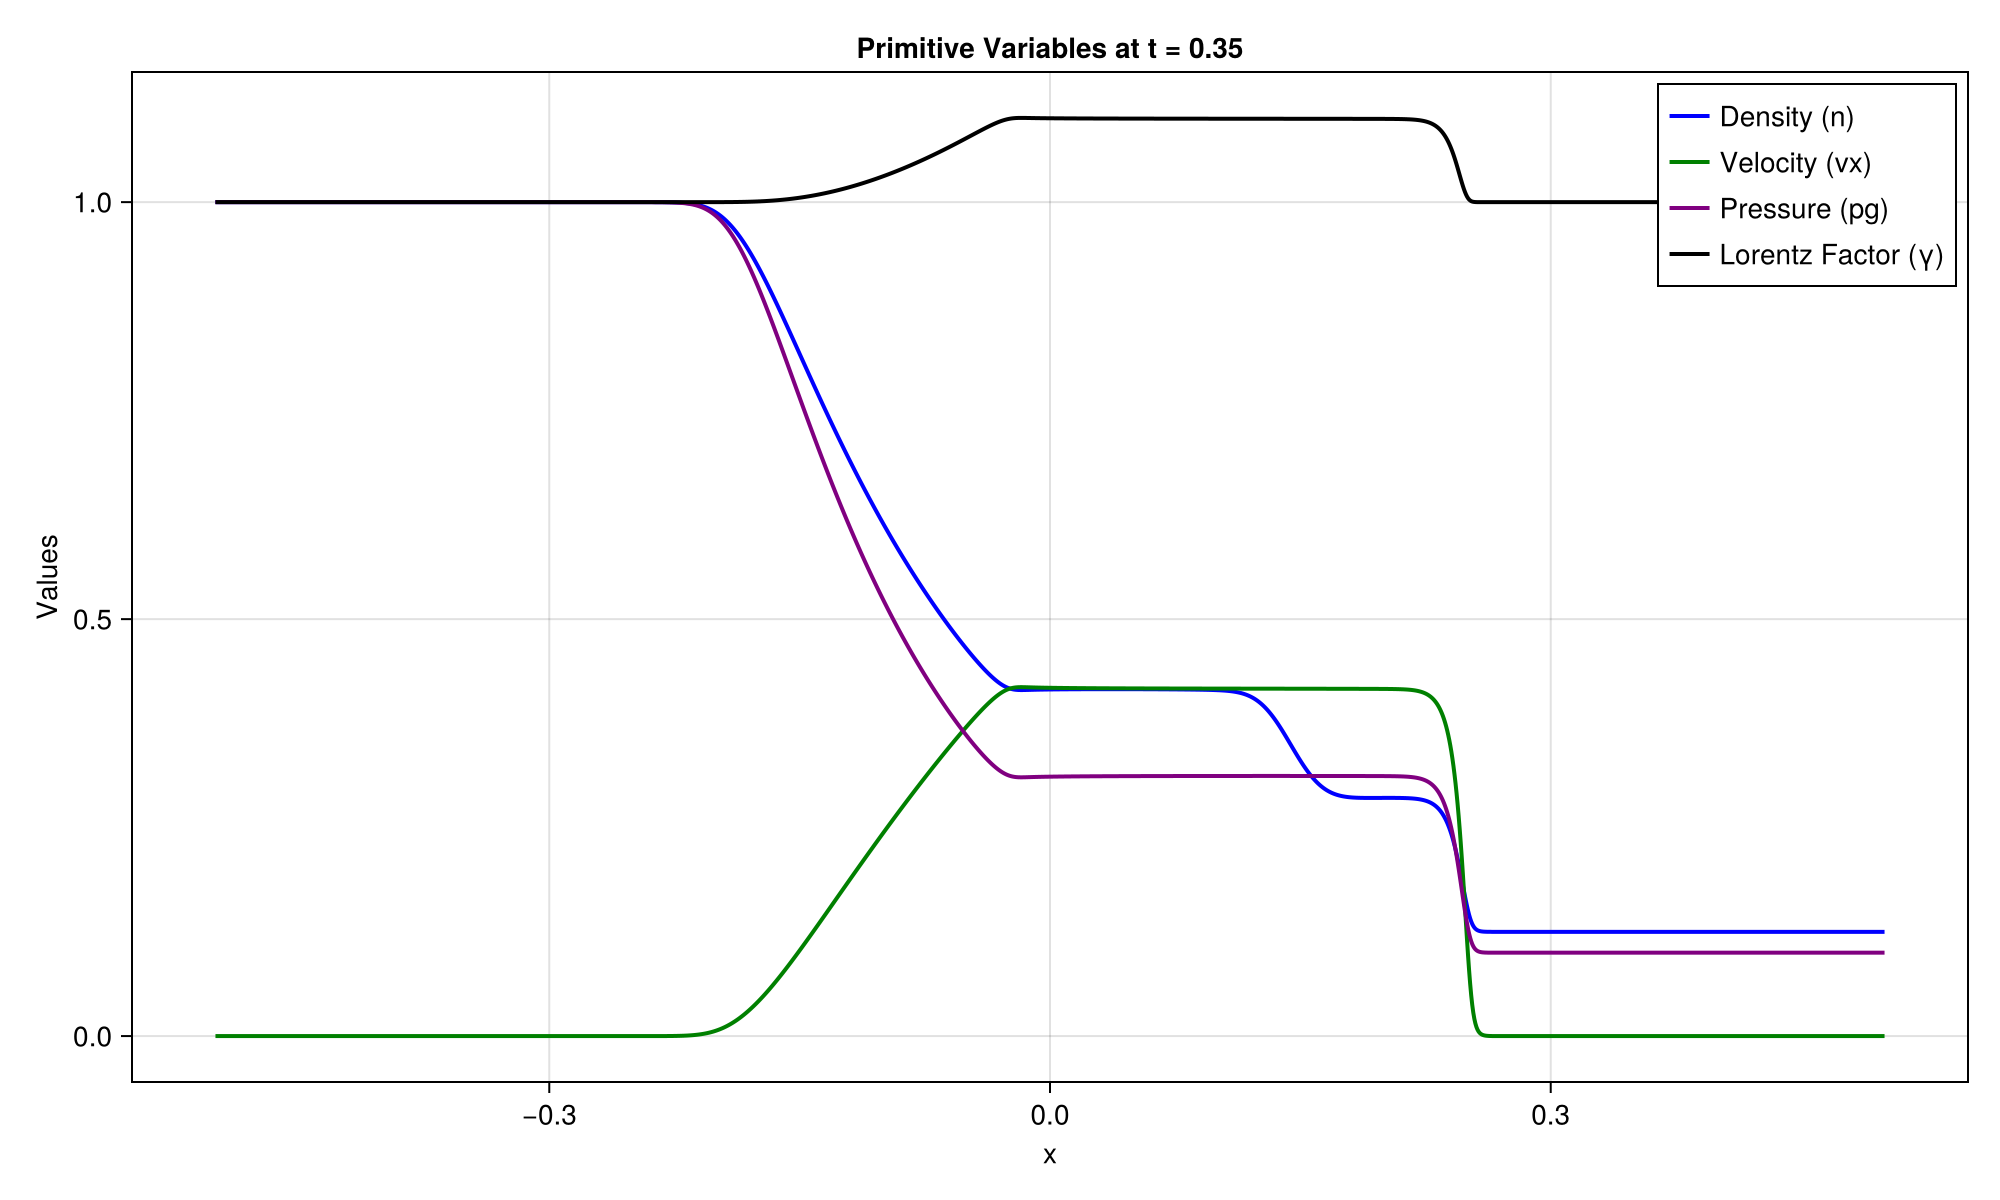

In [20]:
# Save the figure (optional)
# save("relativistic_sod_shock.png", fig, resolution = (1200, 800))

# Alternative: Single plot with all variables
fig2 = Figure(resolution = (1000, 600))
ax = Axis(fig2[1, 1], title = "Primitive Variables at t = $(round(t, digits=3))", 
          xlabel = "x", ylabel = "Values")

lines!(ax, x, n_values, label = "Density (n)", color = :blue, linewidth = 2)
lines!(ax, x, vx_values, label = "Velocity (vx)", color = :green, linewidth = 2)
lines!(ax, x, pg_values, label = "Pressure (pg)", color = :purple, linewidth = 2)
lines!(ax, x, γ_values, label = "Lorentz Factor (γ)", color = :black, linewidth = 2)

axislegend(ax, position = :rt)

fig2

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


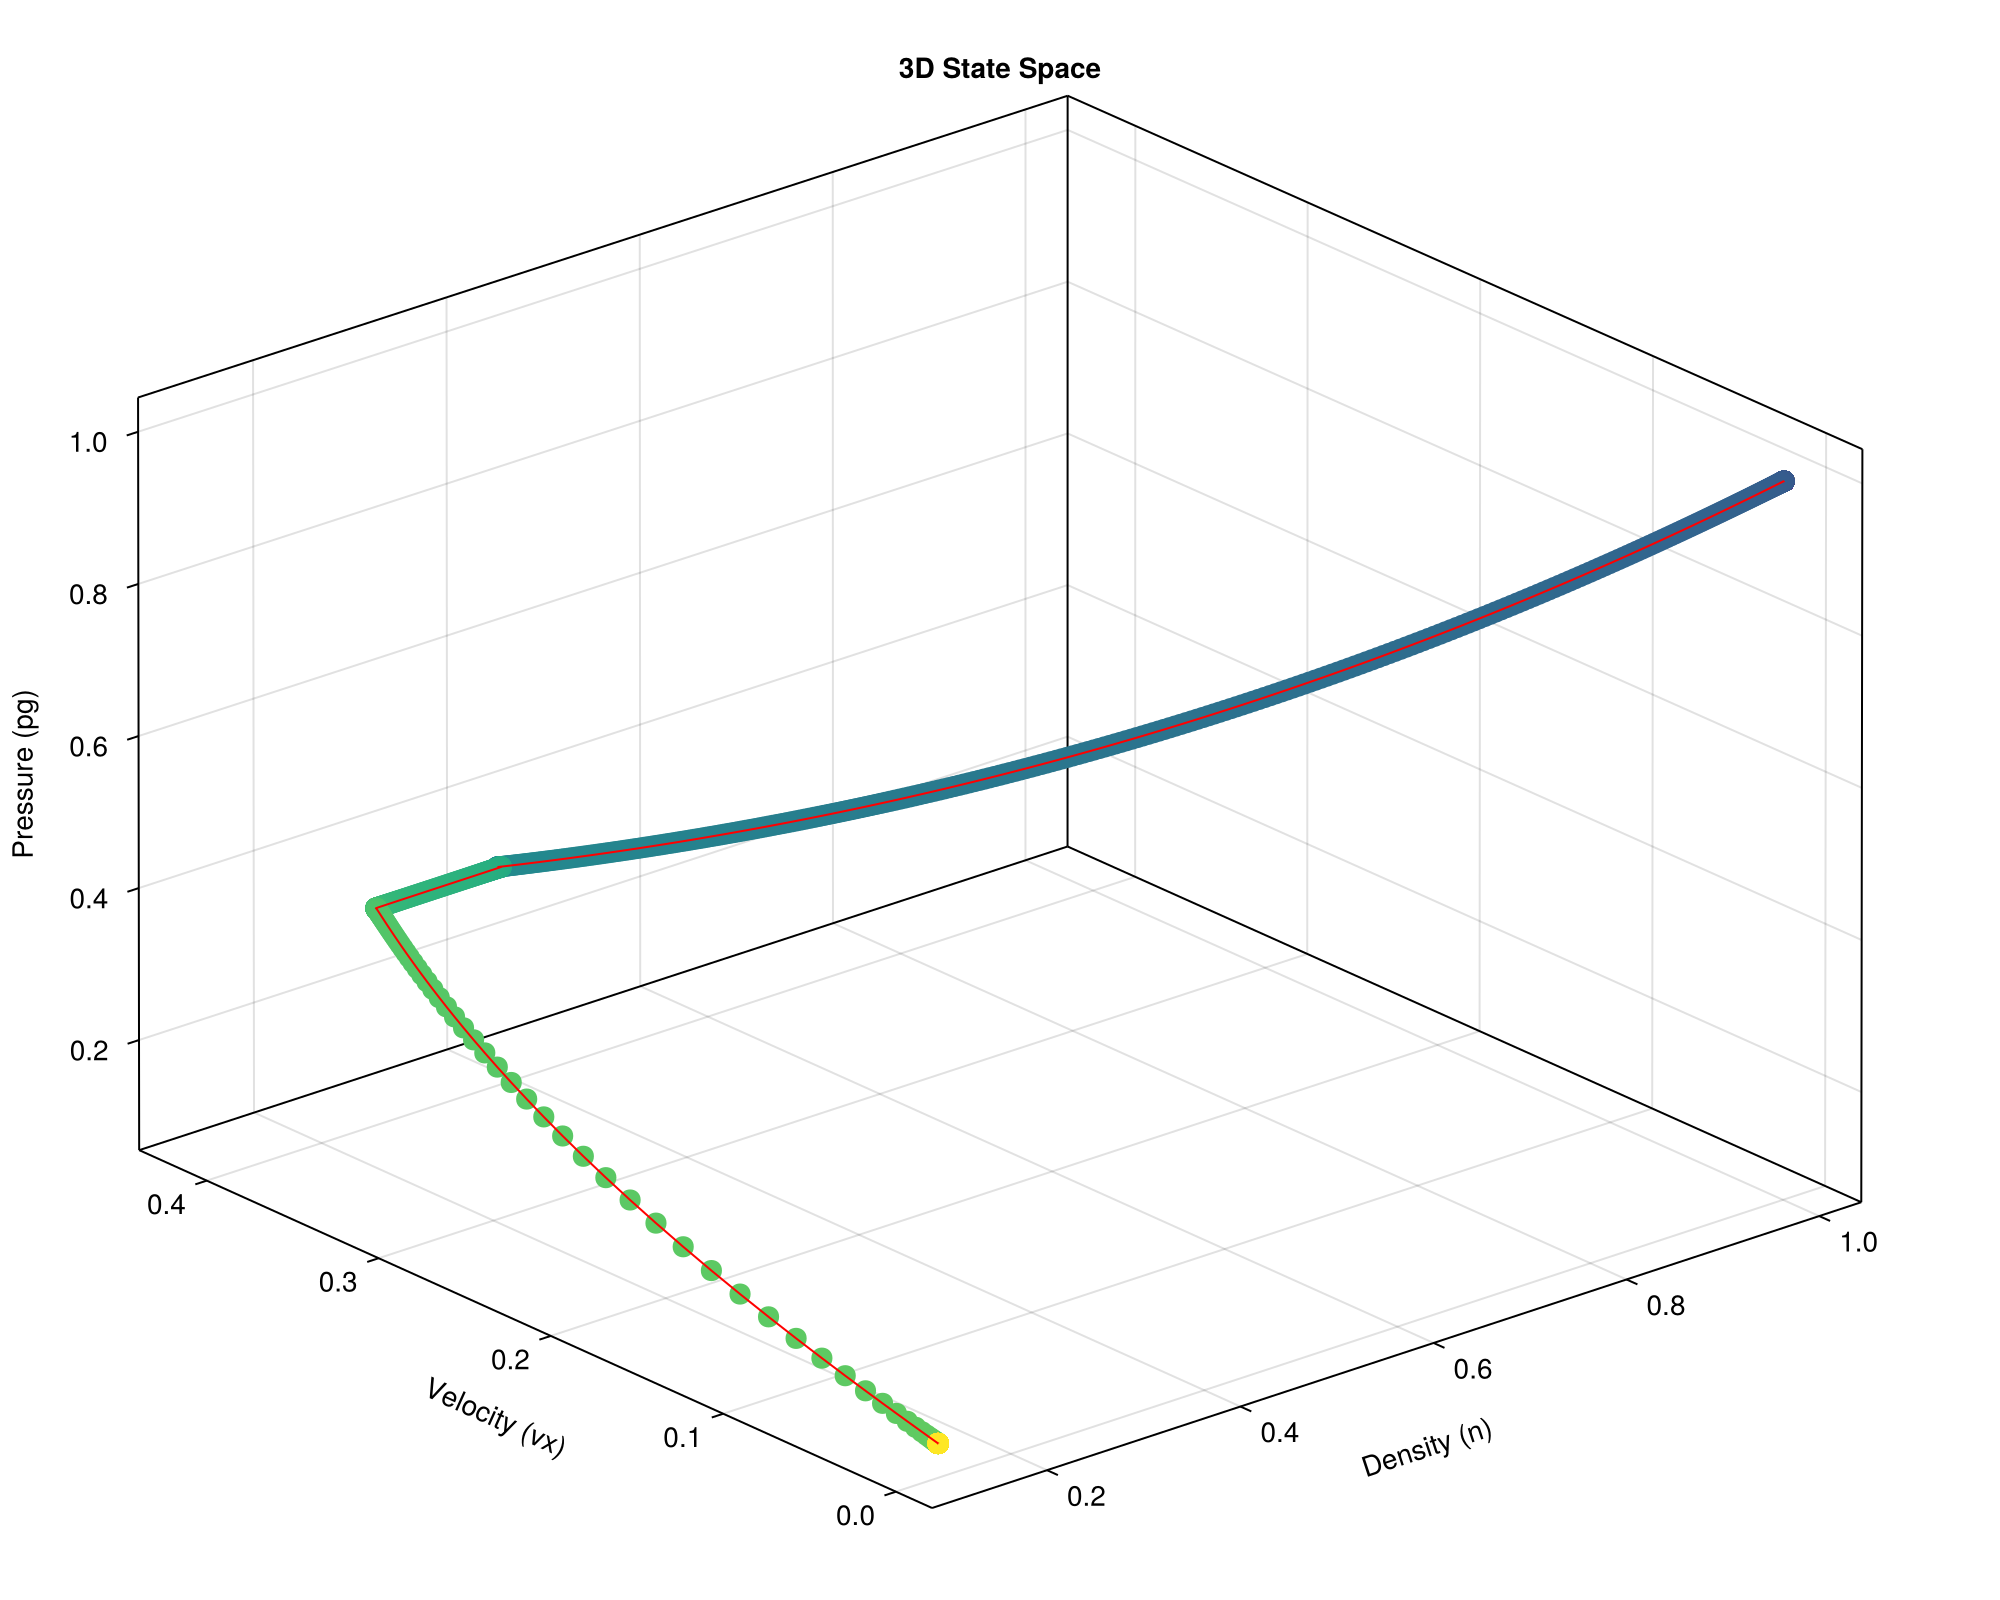

In [21]:
# 3D visualization of the state variables
fig3 = Figure(resolution = (1000, 800))
ax3d = Axis3(fig3[1, 1], title = "3D State Space", 
             xlabel = "Density (n)", ylabel = "Velocity (vx)", zlabel = "Pressure (pg)")

scatter!(ax3d, n_values, vx_values, pg_values, 
         color = 1:length(n_values), colormap = :viridis, markersize = 15)

# Connect points to show the evolution along x
lines!(ax3d, n_values, vx_values, pg_values, color = :red, linewidth = 1)

fig3